In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão de Python Neste Jupyter Notebook:', python_version())

# usaremos o filtro 'waning' para deixar mais limpo.
import warnings
warnings.filterwarnings('ignore')

Versão de Python Neste Jupyter Notebook: 3.10.5


### Representing Agents and Environments

In [2]:
# scripts/agents.py
import random

class Agent(object):

    def __init__(self,env):
        """set up the agent"""
    
        self.env=env

    def go(self,n):
        """acts for n time steps"""

        raise NotImplementedError("go") # abstract method

In [3]:
# scripts/agents.py
from scripts.display import Displayable

class Environment(Displayable):
    def initial_percepts(self):
        """returns the initial percepts for the agent"""

        raise NotImplementedError("initial_percepts") # abstract method

    def do(self,action):
        """does the action in the environment
        returns the next percept """

        raise NotImplementedError("do") # abstract method

### Paper buying agent and environment

In [4]:
# scripts/agents.py
class TP_env(Environment):
    prices = [234, 234, 234, 234, 255, 255, 275, 275, 211, 211, 211,
    234, 234, 234, 234, 199, 199, 275, 275, 234, 234, 234, 234, 255,
    255, 260, 260, 265, 265, 265, 265, 270, 270, 255, 255, 260, 260,
    265, 265, 150, 150, 265, 265, 270, 270, 255, 255, 260, 260, 265,
    265, 265, 265, 270, 270, 211, 211, 255, 255, 260, 260, 265, 265,
    260, 265, 270, 270, 205, 255, 255, 260, 260, 265, 265, 265, 265,
    270, 270]

    max_price_addon = 20 # maximum of random value added to get price

    def __init__(self):
        """paper buying agent"""
        
        self.time=0
        self.stock=20
        self.stock_history = [] # memory of the stock history
        self.price_history = [] # memory of the price history


    def initial_percepts(self):
        """return initial percepts"""
        
        self.stock_history.append(self.stock)
        price = self.prices[0] + random.randrange(self.max_price_addon)
        self.price_history.append(price)
        
        return {'price': price,
                'instock': self.stock}

    def do(self, action):
        """does action (buy) and returns percepts (price and instock)"""

        used = pick_from_dist({6:0.1, 5:0.1, 
                               4:0.2, 3:0.3, 
                               2:0.2, 1:0.1})
        
        bought = action['buy']
        self.stock = self.stock+bought-used
        self.stock_history.append(self.stock)
        self.time += 1
        
        price = (self.prices[self.time%len(self.prices)] # repeating pattern
                 +random.randrange(self.max_price_addon) # plus randomness
                 +self.time//2) # plus inflation
        
        self.price_history.append(price)
        
        return {'price': price,
                'instock': self.stock}

In [5]:
# scripts/agents.py
def pick_from_dist(item_prob_dist):
    """ returns a value from a distribution.
    item_prob_dist is an item:probability dictionary, where the
    probabilities sum to 1.
    returns an item chosen in proportion to its probability
    """

    ranreal = random.random()
    for (it,prob) in item_prob_dist.items():
        if ranreal < prob:
            return it
        else:
            ranreal -= prob
            
    raise RuntimeError(str(item_prob_dist)+" is not a probability distribution")

In [6]:
# scripts/agents.py
class TP_agent(Agent):
    def __init__(self, env):
        self.env = env
        self.spent = 0
        percepts = env.initial_percepts()
        self.ave = self.last_price = percepts['price']
        self.instock = percepts['instock']


    def go(self, n):
        """go for n time steps"""
        
        for i in range(n):
            if self.last_price < 0.9 * self.ave and self.instock < 60:
                tobuy = 48            
            elif self.instock < 12:
                tobuy = 12
            else:
                tobuy = 0
        
            self.spent += tobuy*self.last_price
            percepts = env.do({'buy': tobuy})
            self.last_price = percepts['price']
            self.ave = self.ave+(self.last_price-self.ave)*0.05
            self.instock = percepts['instock']

In [7]:
# scripts/agents.py
env = TP_env()
ag = TP_agent(env)
#ag.go(90)
#ag.spent/env.time ## average spent per time period

In [8]:
# scripts/agents.py
import matplotlib.pyplot as plt

class Plot_prices(object):
    """Set up the plot for history of price and number in stock"""

    def __init__(self, ag,env):
        self.ag = ag
        self.env = env
        plt.ion()

        plt.xlabel("Time")
        plt.ylabel("Number in stock. Price.")

    def plot_run(self):
        """plot history of price and instock"""

        num = len(env.stock_history)

        plt.plot(range(num),env.stock_history,label="In stock")
        plt.plot(range(num),env.price_history,label="Price")

        #plt.legend(loc="upper left")
        plt.draw()

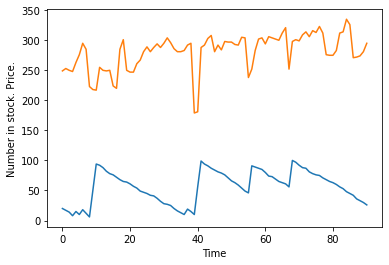

In [10]:
pl = Plot_prices(ag,env)
ag.go(90); pl.plot_run()

In [9]:
%reload_ext watermark
%watermark -a "Caique Miranda" -gu "caiquemiranda" -iv

Author: Caique Miranda

Github username: caiquemiranda

matplotlib: 3.5.2



### End.